Starting enhanced BAC detection pipeline with display-only outputs...
Loading and analyzing data...
Dataset loaded: 1000000 rows, 20 columns
Analyzing column types...
Identified 13 numerical, 3 categorical, 0 text columns
Performing advanced data analysis...


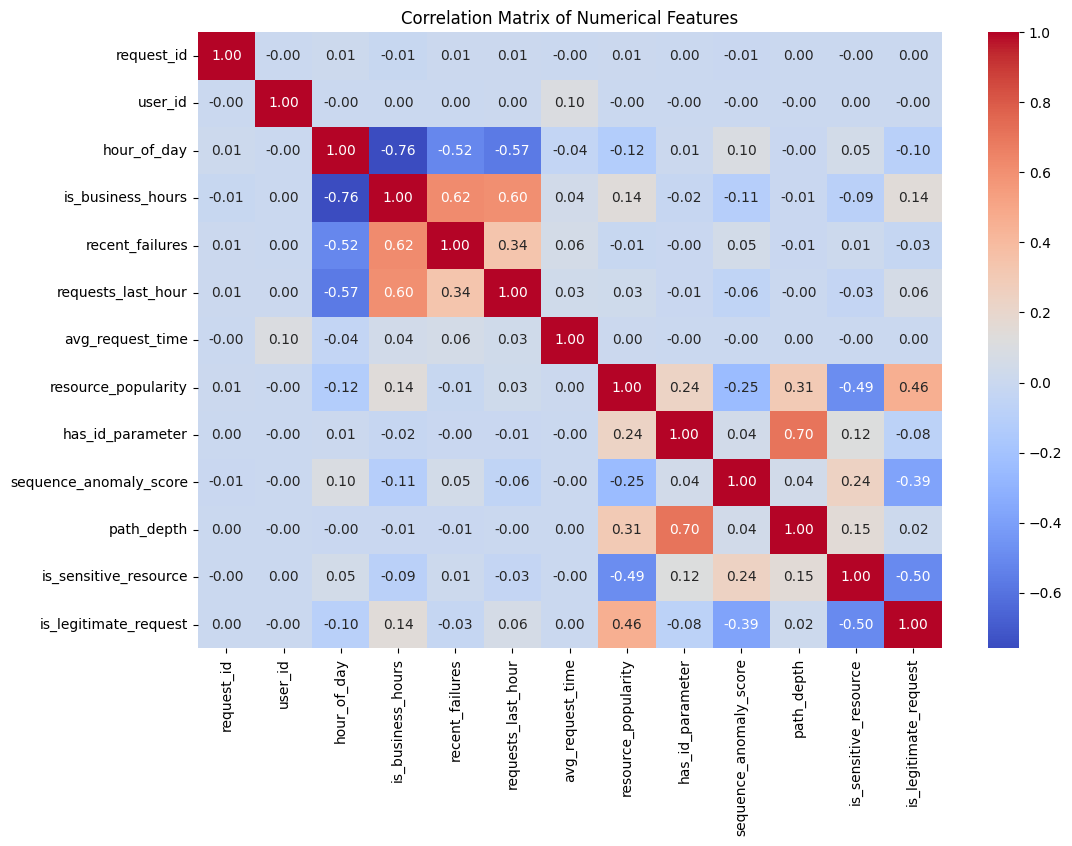

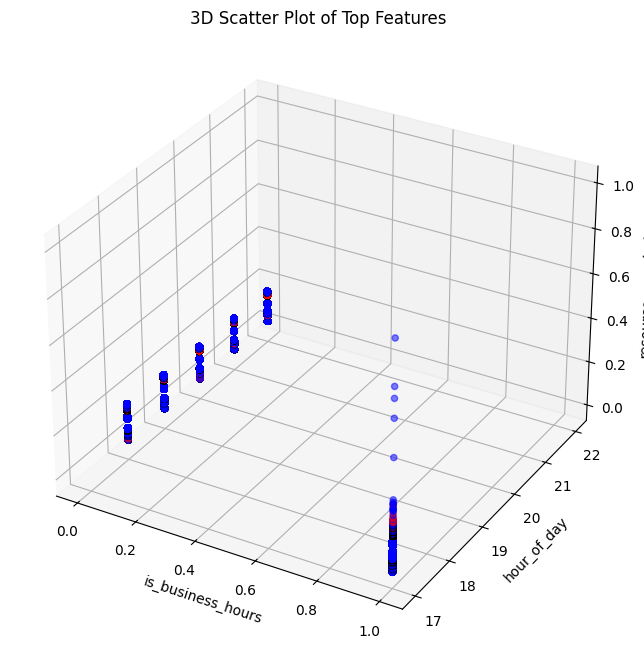

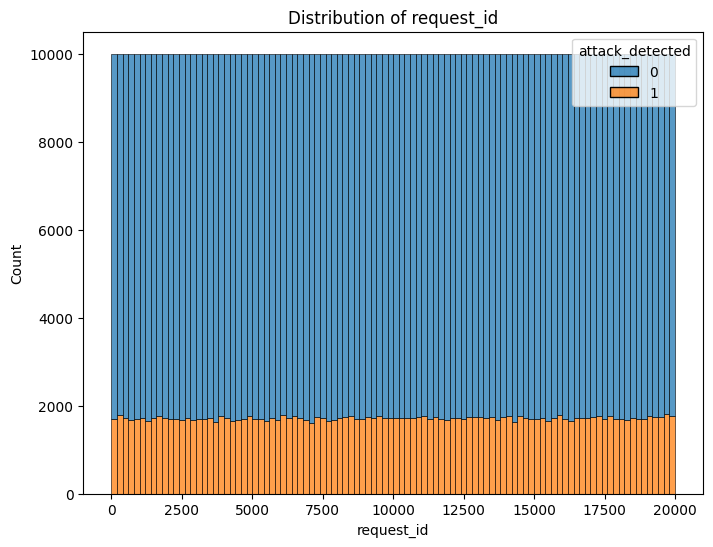

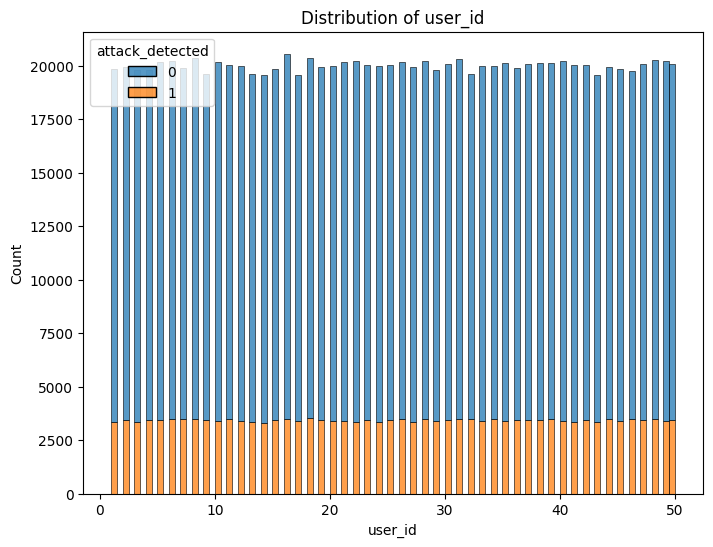

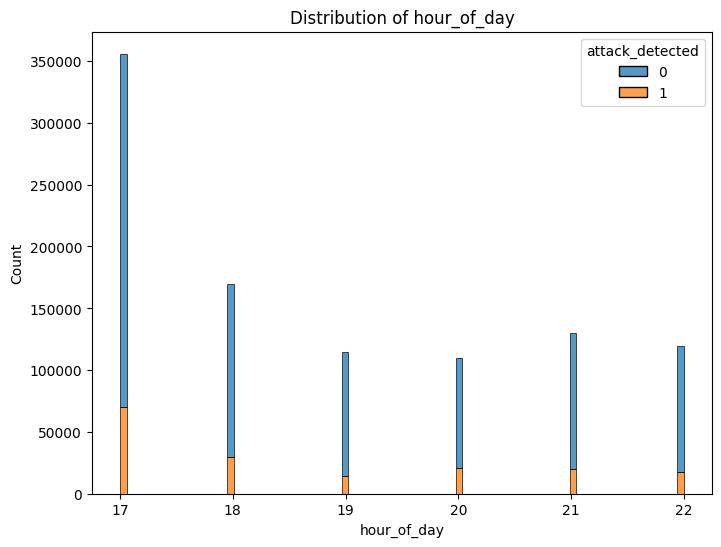

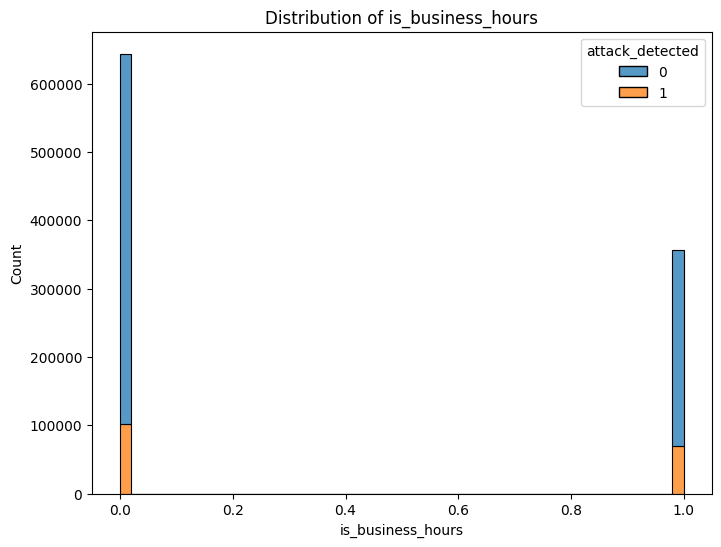

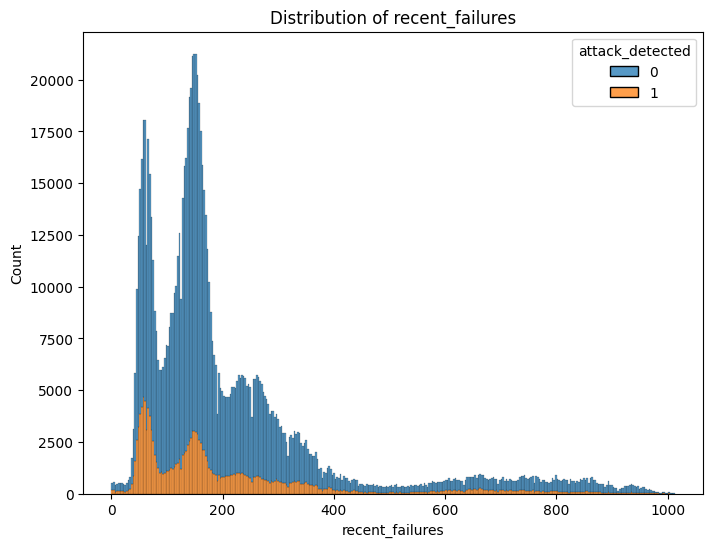

Applying preprocessing pipeline...
Preprocessing complete. Features shape: (1000000, 261)
Performing feature selection...
Selected 100 features
Train shape: (800000, 100), Test shape: (200000, 100)
Training RandomForest...
Evaluating RandomForest...


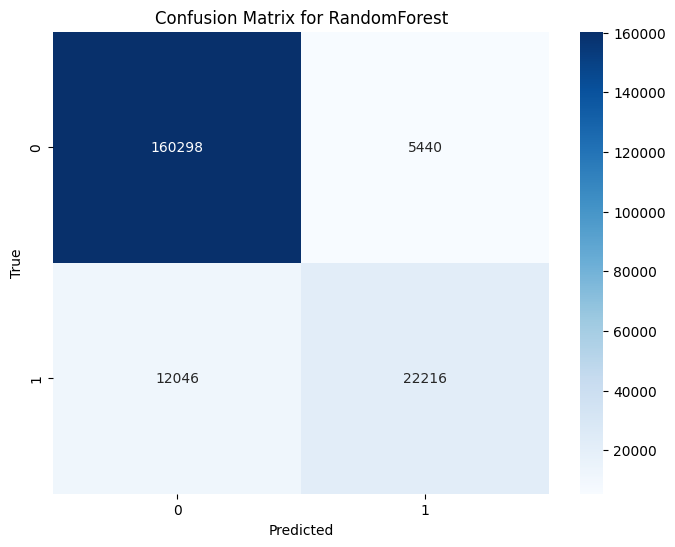

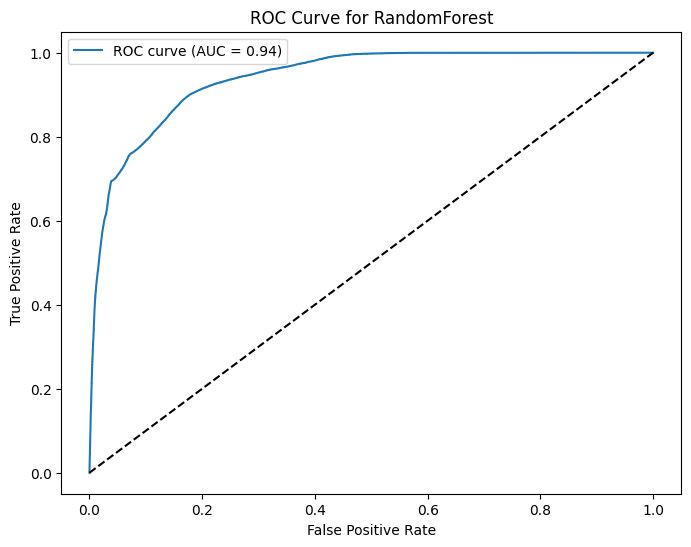

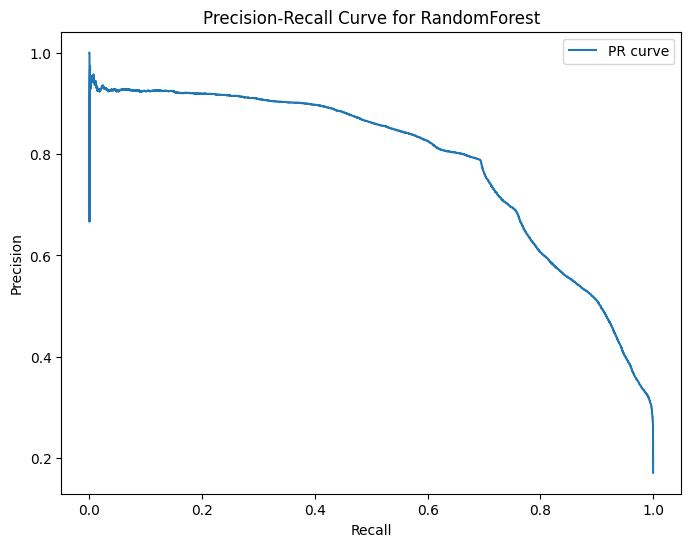

LIME not available, skipping explainability
Completed RandomForest: ROC AUC = 0.9400 in 66.82s
Training LogisticRegression...
Evaluating LogisticRegression...


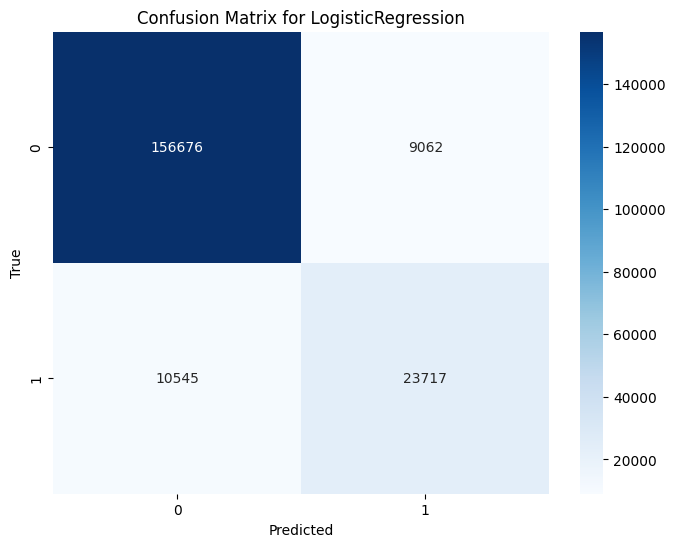

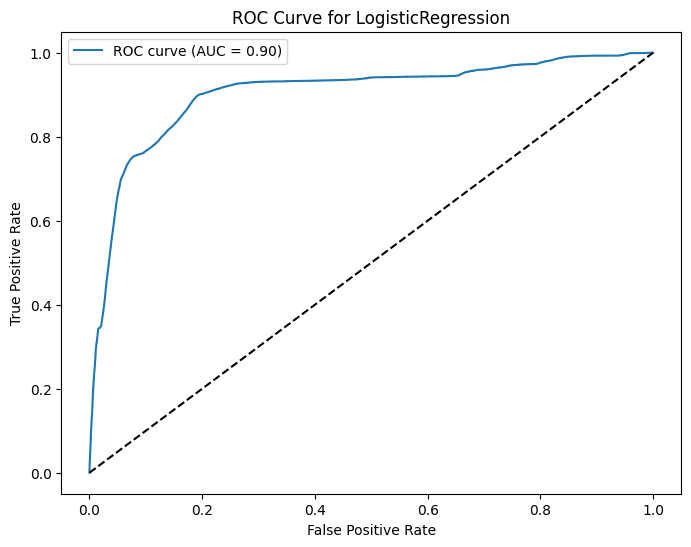

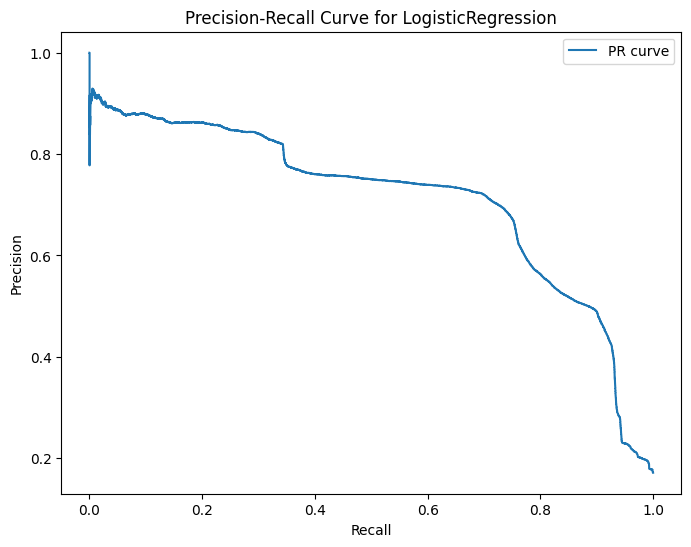

LIME not available, skipping explainability
Completed LogisticRegression: ROC AUC = 0.9032 in 330.74s
Training MLP...
Evaluating MLP...


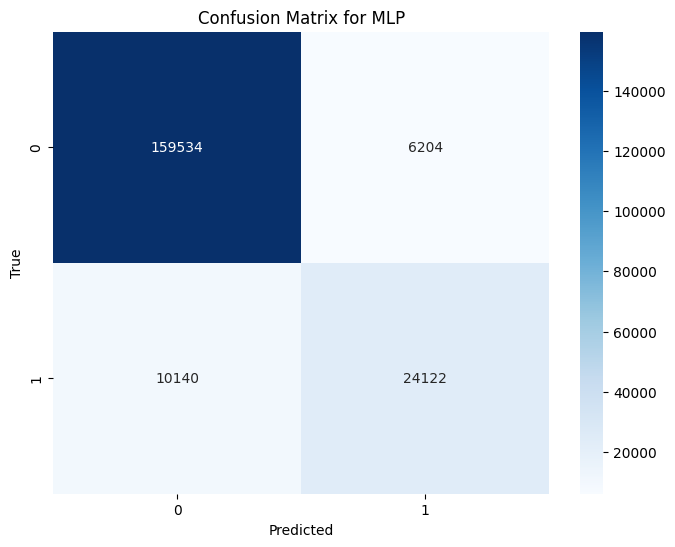

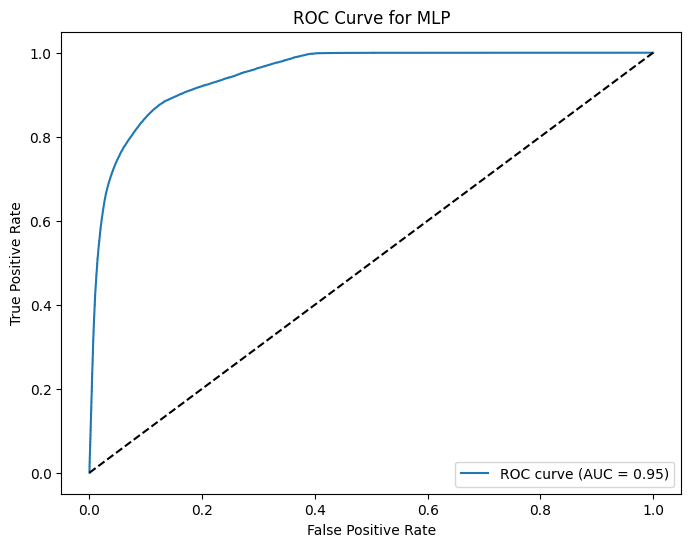

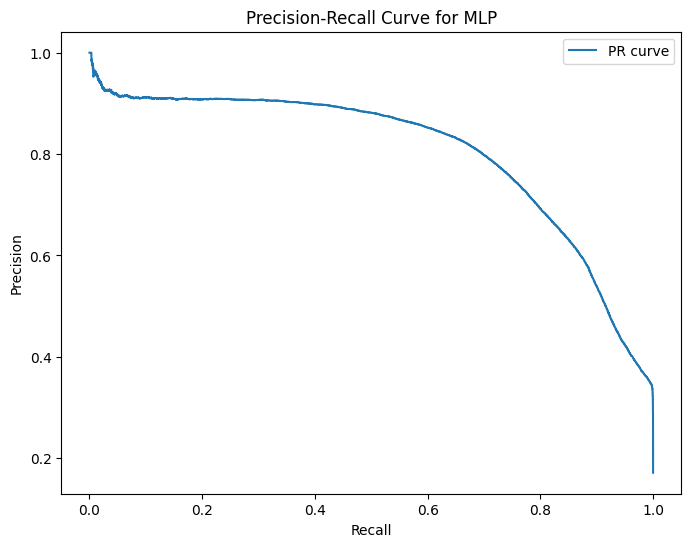

LIME not available, skipping explainability
Completed MLP: ROC AUC = 0.9496 in 562.36s
Training KNN...
Evaluating KNN...


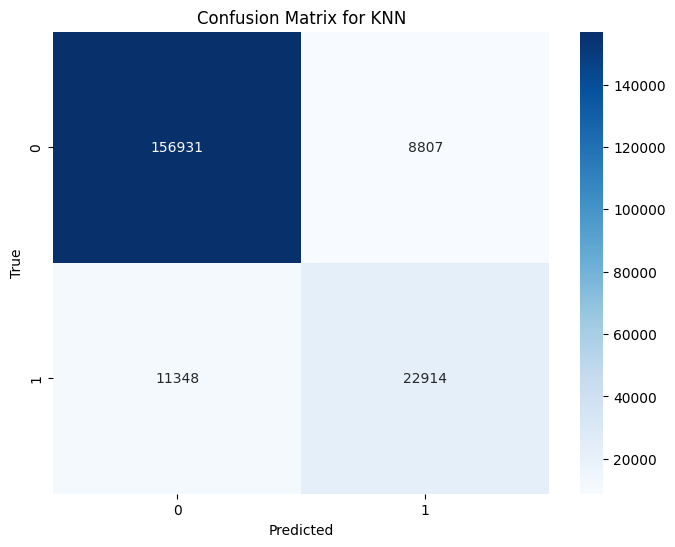

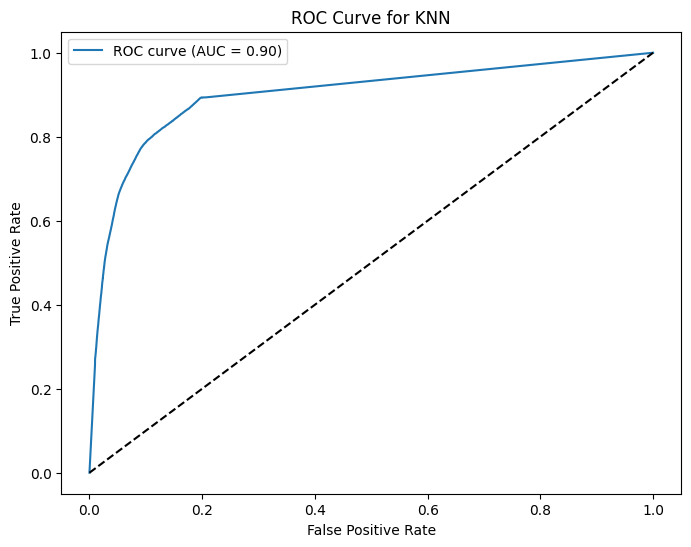

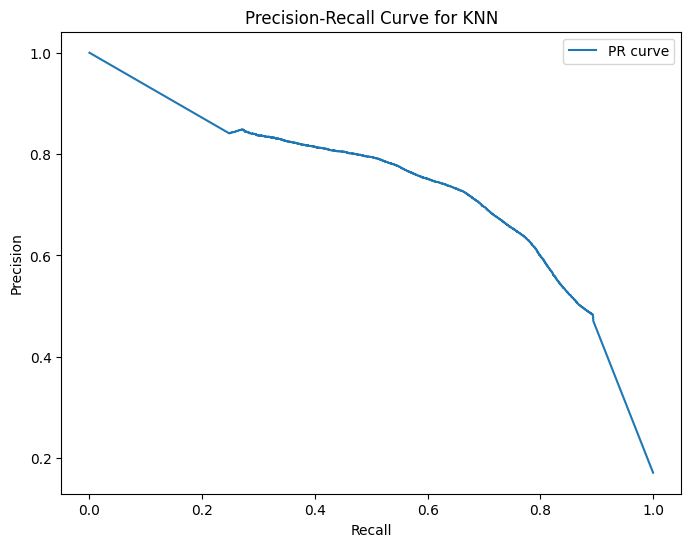

LIME not available, skipping explainability
Completed KNN: ROC AUC = 0.8991 in 0.13s
Training XGBoost...
Evaluating XGBoost...


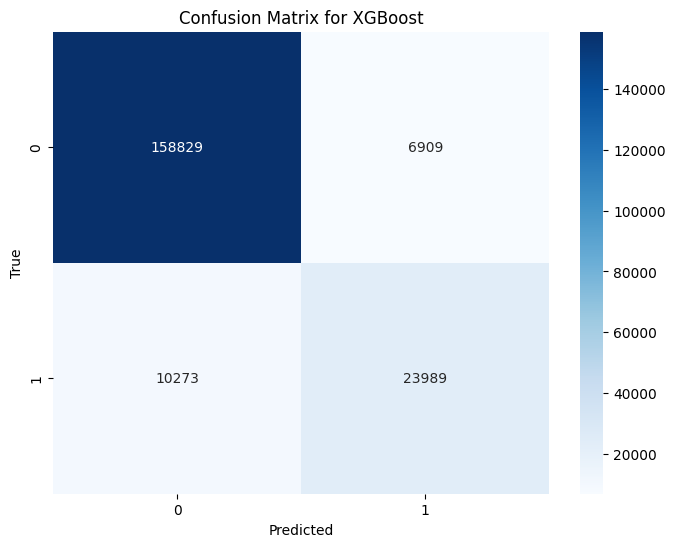

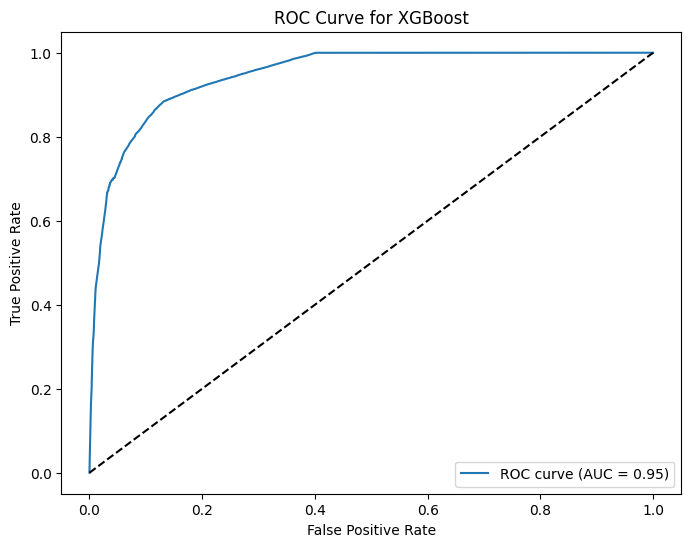

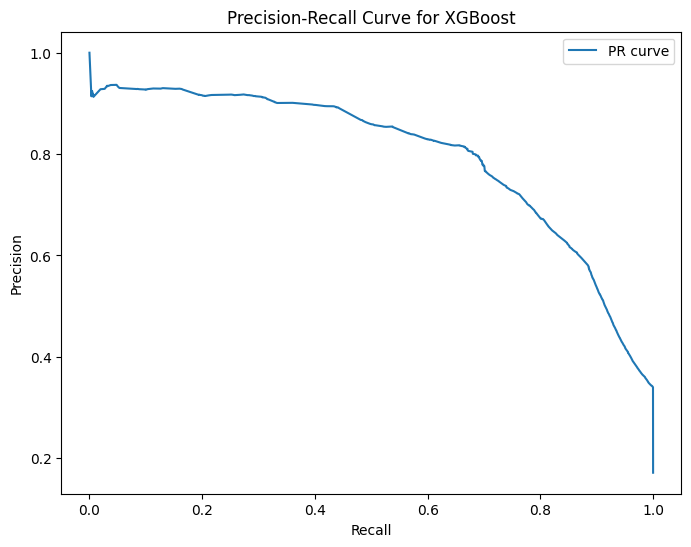

LIME not available, skipping explainability
Completed XGBoost: ROC AUC = 0.9475 in 19.99s
Training LightGBM...
[LightGBM] [Info] Number of positive: 137047, number of negative: 662953
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.231868 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 800000, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.171309 -> initscore=-1.576380
[LightGBM] [Info] Start training from score -1.576380
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

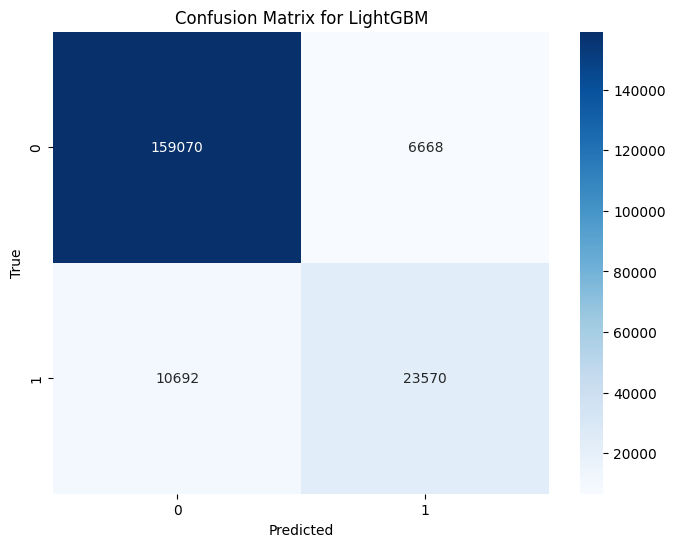

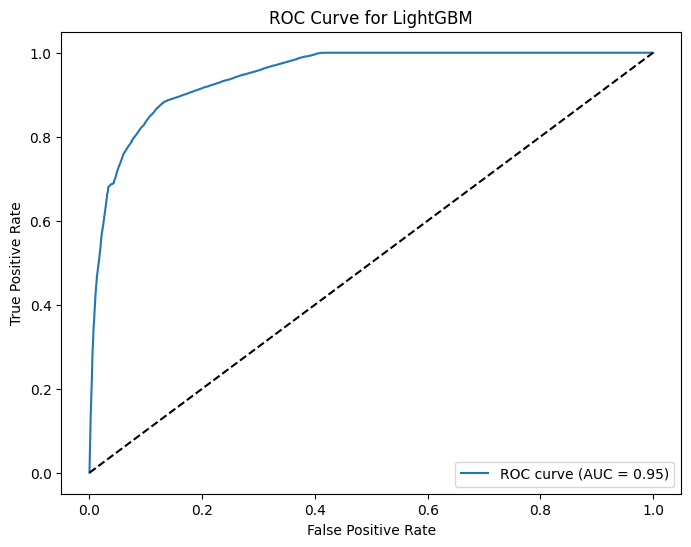

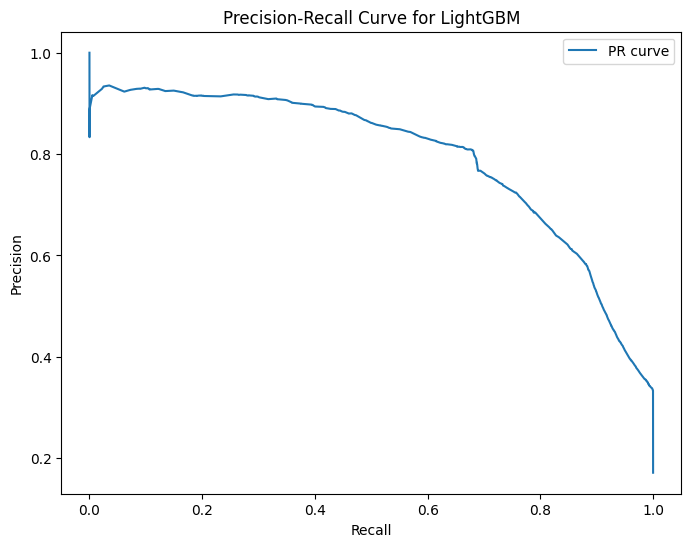

LIME not available, skipping explainability
Completed LightGBM: ROC AUC = 0.9465 in 4.37s
Best model: MLP with ROC AUC = 0.9496

Model Performance Comparison:
                    accuracy  precision    recall        f1   roc_auc  \
RandomForest        0.912570   0.908382  0.912570  0.908760  0.939979   
LogisticRegression  0.901965   0.900383  0.901965  0.901099  0.903175   
MLP                 0.918280   0.915430  0.918280  0.916269  0.949573   
KNN                 0.899225   0.896554  0.899225  0.897668  0.899059   
XGBoost             0.914090   0.911351  0.914090  0.912304  0.947514   
LightGBM            0.913200   0.910030  0.913200  0.911013  0.946510   

                    training_time  
RandomForest            66.820660  
LogisticRegression     330.744716  
MLP                    562.356257  
KNN                      0.129124  
XGBoost                 19.994184  
LightGBM                 4.369263  


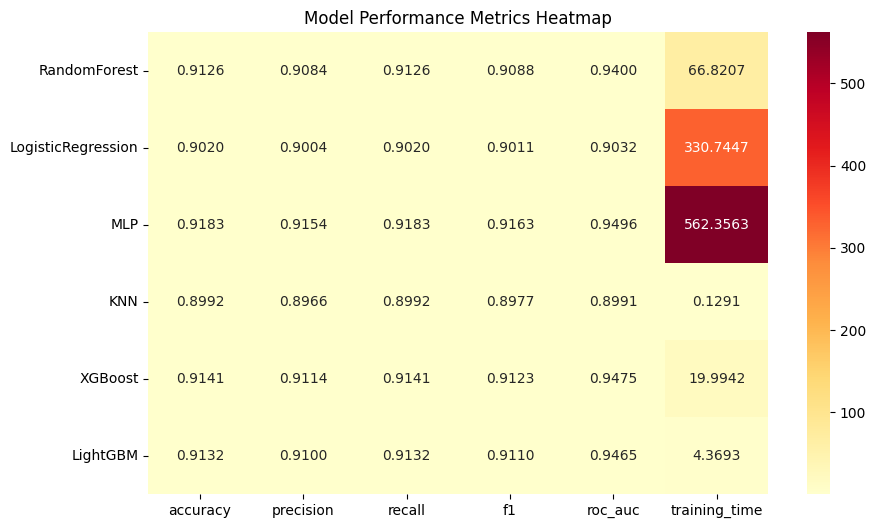

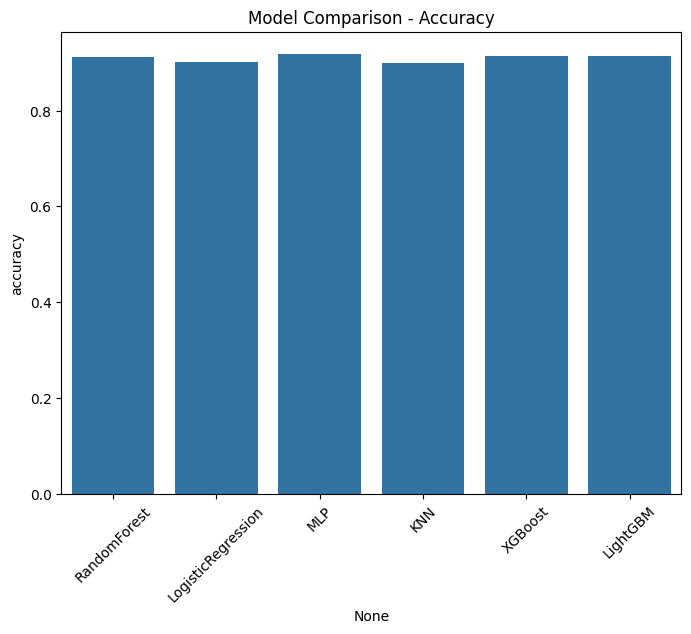

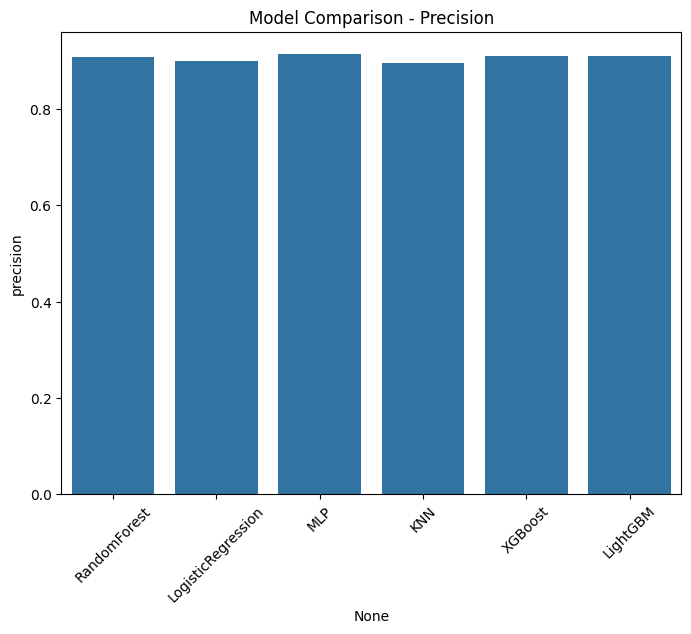

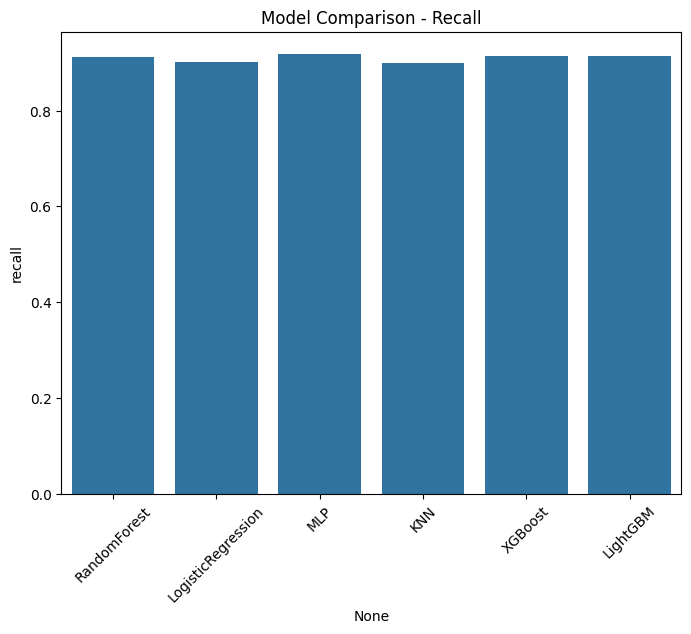

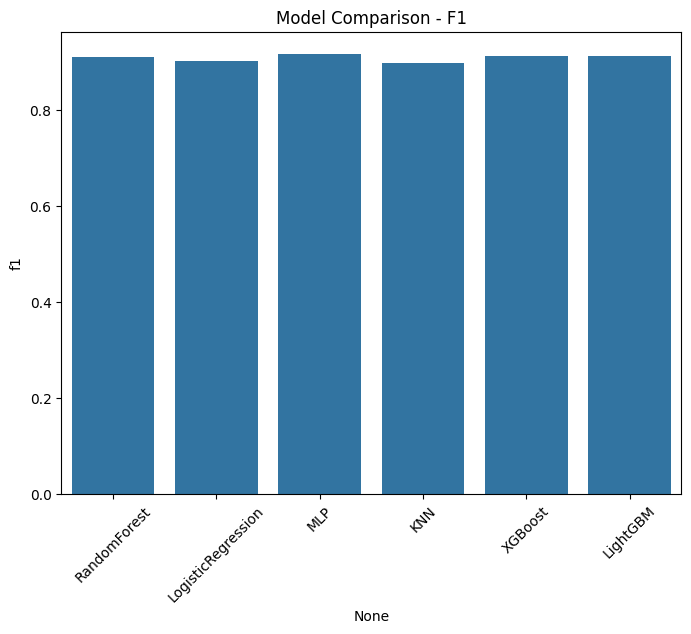

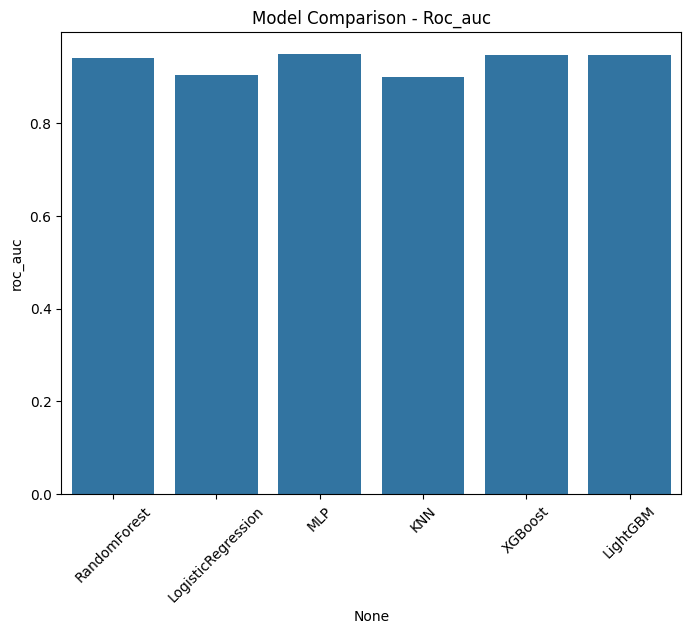


Best model: MLP

Pipeline completed in 26m 1.95s
Performance: ROC AUC = 0.9496, Accuracy = 0.9183


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import os
import gc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
try:
    from xgboost import XGBClassifier
except ImportError:
    XGBClassifier = None
try:
    from lightgbm import LGBMClassifier
except ImportError:
    LGBMClassifier = None
try:
    from catboost import CatBoostClassifier
except ImportError:
    CatBoostClassifier = None
try:
    import lime
    import lime.lime_tabular
except ImportError:
    lime = None

# Track execution time
start_time = time.time()

# Configure settings
n_cores = os.cpu_count()
n_threads = max(1, min(4, n_cores - 1))
os.environ['OMP_NUM_THREADS'] = str(n_threads)
warnings.filterwarnings('ignore')
np.random.seed(42)

print("Starting enhanced BAC detection pipeline with display-only outputs...")

# -----------------------------------
# 1. Data Loading with Type Detection
# -----------------------------------
def load_data():
    try:
        print("Loading and analyzing data...")
        sample = pd.read_csv('ml_training_features.csv', nrows=1000)
        dtype_dict = {}
        for col in sample.columns:
            if col == 'attack_detected':
                continue
            try:
                pd.to_numeric(sample[col])
            except:
                dtype_dict[col] = 'category'
        df = pd.read_csv('ml_training_features.csv', dtype=dtype_dict)
        print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
        if 'attack_detected' not in df.columns:
            print("Error: 'attack_detected' column not found")
            exit(1)
        df = df.dropna(how='all', axis=1)
        nunique = df.nunique()
        cols_to_drop = nunique[nunique <= 1].index
        df = df.drop(columns=cols_to_drop)
        return df
    except FileNotFoundError:
        print("Error: 'ml_training_features.csv' not found")
        exit(1)

# -----------------------------------
# 2. Enhanced Data Analysis with 3D Plots
# -----------------------------------
def analyze_data(df, numerical_cols, categorical_cols):
    print("Performing advanced data analysis...")
    
    # Correlation Matrix
    plt.figure(figsize=(12, 8))
    corr = df[numerical_cols].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix of Numerical Features')
    plt.show()
    
    # 3D Scatter Plot for top 3 numerical features
    if len(numerical_cols) >= 3:
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        top_features = corr.abs().sum().sort_values(ascending=False).index[:3]
        x = df[top_features[0]]
        y = df[top_features[1]]
        z = df[top_features[2]]
        colors = df['attack_detected'].map({0: 'blue', 1: 'red'})
        ax.scatter(x, y, z, c=colors, alpha=0.5)
        ax.set_xlabel(top_features[0])
        ax.set_ylabel(top_features[1])
        ax.set_zlabel(top_features[2])
        ax.set_title('3D Scatter Plot of Top Features')
        plt.show()
    
    # Distribution Plots for Numerical Features
    for col in numerical_cols[:5]:  # Limit to 5 for brevity
        plt.figure(figsize=(8, 6))
        sns.histplot(data=df, x=col, hue='attack_detected', multiple='stack')
        plt.title(f'Distribution of {col}')
        plt.show()

# -----------------------------------
# 3. Data Preprocessing
# -----------------------------------
def prepare_data(df):
    print("Analyzing column types...")
    categorical_cols = []
    numerical_cols = []
    text_cols = []
    
    for col in df.columns:
        if col == 'attack_detected':
            continue
        if pd.api.types.is_categorical_dtype(df[col]):
            categorical_cols.append(col)
        elif pd.api.types.is_numeric_dtype(df[col]):
            numerical_cols.append(col)
        else:
            try:
                pd.to_numeric(df[col])
                numerical_cols.append(col)
            except:
                if df[col].nunique() < 100:
                    categorical_cols.append(col)
                else:
                    text_cols.append(col)
    
    print(f"Identified {len(numerical_cols)} numerical, {len(categorical_cols)} categorical, {len(text_cols)} text columns")
    if text_cols:
        print(f"Dropping text columns: {', '.join(text_cols)}")
        df = df.drop(columns=text_cols)
    
    # Perform data analysis before preprocessing
    analyze_data(df, numerical_cols, categorical_cols)
    
    X = df.drop('attack_detected', axis=1)
    y = df['attack_detected'].values
    
    preprocessor_steps = []
    if numerical_cols:
        preprocessor_steps.append(
            ('num', Pipeline([
                ('imputer', SimpleImputer(strategy='mean')),
                ('scaler', StandardScaler())
            ]), numerical_cols)
        )
    if categorical_cols:
        preprocessor_steps.append(
            ('cat', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
            ]), categorical_cols)
        )
    
    preprocessor = ColumnTransformer(
        transformers=preprocessor_steps,
        remainder='drop',
        n_jobs=1
    )
    
    print("Applying preprocessing pipeline...")
    X_preprocessed = preprocessor.fit_transform(X)
    
    feature_names = preprocessor.get_feature_names_out()
    print(f"Preprocessing complete. Features shape: {X_preprocessed.shape}")
    return X_preprocessed, y, feature_names, numerical_cols, categorical_cols

# -----------------------------------
# 4. Feature Selection
# -----------------------------------
def select_features(X, y, feature_names, max_features=100):
    print("Performing feature selection...")
    selector = RandomForestClassifier(
        n_estimators=30,
        max_depth=10,
        n_jobs=1,
        random_state=42
    )
    
    if X.shape[0] > 10000:
        sample_size = min(10000, int(X.shape[0] * 0.3))
        sample_idx = np.random.choice(X.shape[0], sample_size, replace=False)
        selector.fit(X[sample_idx], y[sample_idx])
    else:
        selector.fit(X, y)
    
    importances = selector.feature_importances_
    n_features = min(max_features, len(feature_names))
    top_indices = np.argsort(importances)[::-1][:n_features]
    X_selected = X[:, top_indices]
    selected_features = [feature_names[i] for i in top_indices]
    print(f"Selected {len(selected_features)} features")
    return X_selected, selected_features

# -----------------------------------
# 5. Train-Test Split
# -----------------------------------
def split_data(X, y):
    train_idx, test_idx = train_test_split(
        np.arange(len(y)), test_size=0.2, stratify=y, random_state=42
    )
    
    X_train = X[train_idx]
    X_test = X[test_idx]
    y_train = y[train_idx]
    y_test = y[test_idx]
    
    print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test

# -----------------------------------
# 6. Model Evaluation with Visualizations
# -----------------------------------
def evaluate_model(name, model, X_test, y_test, y_pred, y_proba, idx):
    print(f"Evaluating {name}...")
    
    # Confusion Matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc_score(y_test, y_proba):.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {name}')
    plt.legend(loc='best')
    plt.show()
    
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'PR curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for {name}')
    plt.legend(loc='best')
    plt.show()

# -----------------------------------
# 7. LIME Explainability
# -----------------------------------
def apply_lime(model, X_train, X_test, feature_names, y_test, model_name, idx):
    if lime is None:
        print("LIME not available, skipping explainability")
        return
    
    print(f"Applying LIME for {model_name}...")
    explainer = lime.lime_tabular.LimeTabularExplainer(
        X_train,
        feature_names=feature_names,
        class_names=['No Attack', 'Attack'],
        mode='classification'
    )
    
    # Explain a few test instances
    for i in range(min(3, X_test.shape[0])):
        exp = explainer.explain_instance(
            X_test[i],
            model.predict_proba,
            num_features=10
        )
        fig = exp.as_pyplot_figure()
        plt.title(f'LIME Explanation for {model_name} - Instance {i+1}')
        plt.show()

# -----------------------------------
# 8. Model Training
# -----------------------------------
def train_models(X_train, y_train, X_test, y_test, feature_names):
    gc.collect()
    models = {
        'RandomForest': RandomForestClassifier(
            n_estimators=50,
            max_depth=10,
            min_samples_split=20,
            n_jobs=1,
            random_state=42
        ),
        'LogisticRegression': LogisticRegression(
            max_iter=300,
            solver='saga',
            C=0.1,
            n_jobs=1,
            random_state=42
        ),
        'MLP': MLPClassifier(
            hidden_layer_sizes=(100, 50),
            max_iter=300,
            learning_rate='adaptive',
            random_state=42
        ),
        'KNN': KNeighborsClassifier(
            n_neighbors=5,
            weights='distance',
            n_jobs=1
        )
    }
    
    if XGBClassifier:
        models['XGBoost'] = XGBClassifier(
            n_estimators=50,
            max_depth=4,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            tree_method='hist',
            n_jobs=1,
            random_state=42,
            eval_metric='logloss'
        )
    
    if LGBMClassifier:
        models['LightGBM'] = LGBMClassifier(
            n_estimators=50,
            max_depth=4,
            learning_rate=0.1,
            num_leaves=31,
            random_state=42,
            n_jobs=1
        )
    
    if CatBoostClassifier:
        models['CatBoost'] = CatBoostClassifier(
            iterations=50,
            depth=4,
            learning_rate=0.1,
            random_seed=42,
            thread_count=1,
            verbose=0
        )
    
    results = {}
    for idx, (name, model) in enumerate(models.items()):
        try:
            print(f"Training {name}...")
            start = time.time()
            model.fit(X_train, y_train)
            train_time = time.time() - start
            
            y_pred = model.predict(X_test)
            y_proba = model.predict_proba(X_test)[:, 1]
            
            report = classification_report(y_test, y_pred, output_dict=True)
            roc_score = roc_auc_score(y_test, y_proba)
            
            results[name] = {
                'name': name,
                'model': model,
                'metrics': {
                    'accuracy': report['accuracy'],
                    'precision': report['weighted avg']['precision'],
                    'recall': report['weighted avg']['recall'],
                    'f1': report['weighted avg']['f1-score'],
                    'roc_auc': roc_score
                },
                'train_time': train_time,
                'predictions': (y_pred, y_proba)
            }
            
            evaluate_model(name, model, X_test, y_test, y_pred, y_proba, idx)
            apply_lime(model, X_train, X_test, feature_names, y_test, name, idx)
            
            print(f"Completed {name}: ROC AUC = {roc_score:.4f} in {train_time:.2f}s")
            gc.collect()
            
        except Exception as e:
            print(f"Error training {name}: {e}")
    
    return results

# -----------------------------------
# 9. Model Comparison and Heatmap
# -----------------------------------
def compare_models(results):
    models_df = pd.DataFrame({
        name: result['metrics']
        for name, result in results.items()
    }).T
    models_df['training_time'] = [result['train_time'] for name, result in results.items()]
    
    print("\nModel Performance Comparison:")
    print(models_df)
    
    # Heatmap of metrics
    plt.figure(figsize=(10, 6))
    sns.heatmap(models_df, annot=True, cmap='YlOrRd', fmt='.4f')
    plt.title('Model Performance Metrics Heatmap')
    plt.show()
    
    # Bar plot of metrics
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    for metric in metrics:
        plt.figure(figsize=(8, 6))
        sns.barplot(x=models_df.index, y=models_df[metric])
        plt.title(f'Model Comparison - {metric.capitalize()}')
        plt.xticks(rotation=45)
        plt.show()

# -----------------------------------
# 10. Analysis and Visualization
# -----------------------------------
def analyze_and_visualize(best_model, all_results, X_test, y_test, selected_features):
    compare_models(all_results)
    
    y_pred, _ = best_model['predictions']
    
    if hasattr(best_model['model'], 'feature_importances_'):
        importances = best_model['model'].feature_importances_
        indices = np.argsort(importances)[::-1]
        plt.figure(figsize=(10, 6))
        plt.title('Feature Importances')
        plt.bar(range(min(20, len(selected_features))), importances[indices][:20])
        plt.xticks(range(min(20, len(selected_features))), 
                  [selected_features[i] for i in indices][:20], rotation=90)
        plt.tight_layout()
        plt.show()
        
        print("\nTop 5 Important Features:")
        for i in range(min(5, len(selected_features))):
            print(f"{i+1}. {selected_features[indices[i]]} - {importances[indices[i]]:.4f}")
    
    elif hasattr(best_model['model'], 'coef_'):
        coef = best_model['model'].coef_[0]
        indices = np.argsort(np.abs(coef))[::-1]
        plt.figure(figsize=(10, 6))
        plt.title('Feature Coefficients (Absolute Values)')
        plt.bar(range(min(20, len(selected_features))), np.abs(coef[indices][:20]))
        plt.xticks(range(min(20, len(selected_features))), 
                  [selected_features[i] for i in indices][:20], rotation=90)
        plt.tight_layout()
        plt.show()
        
        print("\nTop 5 Important Features (by coefficient):")
        for i in range(min(5, len(selected_features))):
            print(f"{i+1}. {selected_features[indices[i]]} - {np.abs(coef[indices[i]]):.4f}")

# -----------------------------------
# 11. Final Report
# -----------------------------------
def save_and_report(model):
    print(f"\nBest model: {model['name']}")
    total_time = time.time() - start_time
    minutes, seconds = divmod(total_time, 60)
    print(f"\nPipeline completed in {int(minutes)}m {seconds:.2f}s")
    print(f"Performance: ROC AUC = {model['metrics']['roc_auc']:.4f}, Accuracy = {model['metrics']['accuracy']:.4f}")

# -----------------------------------
# Main Execution Pipeline
# -----------------------------------
def run_pipeline():
    try:
        df = load_data()
        X, y, feature_names, numerical_cols, categorical_cols = prepare_data(df)
        del df
        gc.collect()
        
        X_selected, selected_features = select_features(X, y, feature_names)
        del X
        gc.collect()
        
        X_train, X_test, y_train, y_test = split_data(X_selected, y)
        del X_selected
        gc.collect()
        
        results = train_models(X_train, y_train, X_test, y_test, selected_features)
        best_model = max(results.values(), key=lambda x: x['metrics']['roc_auc'])
        print(f"Best model: {best_model['name']} with ROC AUC = {best_model['metrics']['roc_auc']:.4f}")
        
        analyze_and_visualize(best_model, results, X_test, y_test, selected_features)
        save_and_report(best_model)
        
    except MemoryError:
        print("Memory Error: Dataset too large for available RAM.")
        exit(1)
    except Exception as e:
        print(f"Error in pipeline: {e}")
        import traceback
        traceback.print_exc()
        exit(1)

if __name__ == "__main__":
    run_pipeline()